In [411]:
%matplotlib inline
import os
import pandas as pd
from pandas.tools.plotting import scatter_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import scale, RobustScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

sns.set_style('whitegrid')

# GTEx Metadata Feature Selection

- The Good: Tons and tons of metadata for GTEx!
- The Bad: 301 features to go through
- The Ugly: About 200 of the columns have no interpretable description and they aren't part of the description tables provided by GTEx. Google has also failed to associate GTEx with the abbreviations of the unknown headers.

So let's first determine which features are actually important and worry about deriving their meaning later.

In [373]:
gtex = pd.read_csv('gtex-sample-metadata.tsv', sep='\t')
gtex.head(2)

,rail_id,Run,RailRnaBatchNumber,BigWigPath,dbGaP_Subject_ID,dbGaP_Sample_ID,SUBJID,SAMPID,SAMPLE_USE,ReleaseDate,LoadDate,spots,bases,spots_with_mates,avgLength,size_MB,AssemblyName,download_path,Experiment,LibraryName,LibraryStrategy,LibrarySelection,LibrarySource,LibraryLayout,InsertSize,InsertDev,Platform,Model,SRAStudy,BioProject,Study_Pubmed_id,ProjectID,Sample,BioSample,SampleType,TaxID,ScientificName,SampleName,g1k_pop_code,source,g1k_analysis_group,Subject_ID,Sex,Disease,Tumor,Affection_Status,Analyte_Type,Histological_Type,Body_Site,CenterName,Submission,dbgap_study_accession,Consent,RunHash,ReadHash,SMATSSCR,SMCAT,SMCENTER,SMMTRLTP,SMNOTES,SMOMTRLTP,SMPTHNTS,SMRIN,SMSMPSTE,SMSTYP,SMTS,SMTSC,SMTSD,SMUBRID,SMUBRTRM,SMTSISCH,SMTSPAX,SMTSTPTREF,SMNABTCH,SMNABTCHT,SMNABTCHD,SMGEBTCH,SMGEBTCHD,SMGEBTCHT,ANALYTE_TYPE,SMTORMVE,SMFLGRMRK,SMAFRZE,SMGTC,SME2MPRT,SMCHMPRS,SMNTRART,SMNUMGPS,SMMAPRT,SMEXNCRT,SM550NRM,SMGNSDTC,SMUNMPRT,SM350NRM,SMRDLGTH,SMMNCPB,SME1MMRT,SMSFLGTH,SMESTLBS,SMMPPD,SMNTERRT,SMRRNANM,SMRDTTL,SMVQCFL,SMMNCV,SMTRSCPT,SMMPPDPR,SMCGLGTH,SMGAPPCT,SMUNPDRD,SMNTRNRT,SMMPUNRT,SMEXPEFF,SMMPPDUN,SME2MMRT,SME2ANTI,SMALTALG,SME2SNSE,SMMFLGTH,SME1ANTI,SMSPLTRD,SMBSMMRT,SME1SNSE,SME1PCTS,SMRRNART,SME1MPRT,SMNUM5CD,SMDPMPRT,SME2PCTS,COHORT,GENDER,AGE,RACE,ETHNCTY,HGHT,HGHTU,WGHT,WGHTU,BMI,INCEXC,TRISCH,TRISCHD,TRCHSTIN,TRCHSTIND,TRCCLMP,TRCCLMPD,TRORGNS,TRAMP,TRCRTMP,TRCRTMPU,TRCRTMPL,TRTPTREF,TRVNTSR,TRDNISCH,DTHPRNINT,DTHTPTREF,DTHATPSY,DTHRFG,DTHCERT,DTHVNT,DTHFUCOD,DTHHRDY,DTHCOD,DTHFUCODDU,DTHFUCODD,DTHCODDU,DTHCODD,DTHLUCODDU,DTHLUCODD,DTHLUCOD,DTHMNNR,DTHRFGDU,DTHRFGD,DTHDTRMN,DTHPLCE,DTHVNTDU,DTHVNTD,DTHWTNS,DTHCLS,DTHTYP,DTHCAT,DTHICD10,LBCMVTAB,LBEBVGAB,LBEBVMAB,LBHBCABM,LBHBCABT,LBHBSAB,LBHBSAG,LBHCV1NT,LBHBHCVAB,LBHIV1NT,LBHIVAB,LBHIVO,LBPRRVDRL,LBRPR,MHABNWBC,MHALS,MHALZDMT,MHALZHMR,MHARTHTS,MHASCITES,MHASTHMA,MHBCTINF,MHBLDDND,MHBLDDNDR,MHBLDOCNT,MHCANCER5,MHCANCERC,MHCANCERNM,MHCLLULTS,MHCLRD,MHCOCAINE5,MHCOPD,MHCOUGHU,MHCVD,MHDLYSIS,MHDMNTIA,MHDPRSSN,MHDTND72H,MHENCEPHA,MHEURO5,MHFLU,MHFNGINF,MHFVRU,MHGENCMT,MHGNRR12M,MHHEPBCT,MHHEPCCT,MHHEROIN,MHHGH,MHHIVCT,MHHIVNT,MHHMPHLIA,MHHMPHLIAB,MHHRTATT,MHHRTDIS,MHHRTDISB,MHHTN,MHINFLNE,MHIVDRG5,MHJAKOB,MHLAPTHU,MHLUPUS,MHLVRDIS,MHMENINA,MHMS,MHMSXWMA,MHMSXWMB,MHNEPH,MHNGHTSWT,MHNPHYS4W,MHNRTHEUR,MHOPNWND,MHOPPINF,MHORGNTP,MHOSTMYLTS,MHPLLABS,MHPNMIAB,MHPNMNIA,MHPRCNP,MHPRKNSN,MHPSBLDCLT,MHRA,MHRBSANML,MHREYES,MHRNLFLR,MHSARS,MHSCHZ,MHSCLRDRM,MHSDRGABS,MHSEPSIS,MHSKNSPT,MHSMLPXCT,MHSMLPXVC,MHSRC,MHSRCDSS,MHSRGHM,MHSTD,MHSTRDLT,MHSUBABSA,MHSUBABSB,MHSXMDA,MHSXMDB,MHSYPH12M,MHSZRSU,MHT1D,MHT2D,MHTBHX,MHTEMPU,MHTTCMT,MHTTOO12M,MHTTOONP,MHTXCEXP,MHUK8096,MHUREMIA,MHWKNSSU,MHWNVCT,MHWNVHX,MHWTLSUA,MHWTLSUB
0,3864,SRR660824,19,/dcl01/leek/data/gtex/batch_19/coverage_bigwig...,678145,914544,GTEX-QMR6,GTEX-QMR6-1926-SM-32PL9,Seq_RNA_WTSS; Seq_RNA_Expression,"Feb 02, 2013","Oct 03, 2014",111908147,17010038344,111908147,152,8356,GRCh37,@dbgap@:reads/SRP012682/SRS389722/SRX222703/SR...,SRX222703,Solexa-115781,RNA-Seq,cDNA,TRANSCRIPTOMIC,PAIRED,298,249.730,ILLUMINA,Illumina HiSeq 2000,SRP012682,PRJNA75899,NaN,75899,SRS389722,SAMN01887223,simple,9606,Homo sapiens,GTEX-QMR6-1926-SM-32PL9,NaN,NaN,NaN,678145,male,NaN,no,NaN,RNA:Total RNA,Lung,Lung,BI,SRA066005,phs000424,GRU,A2F688E721CC24EF68372F5DE609B152,15C5209F0D195CD188B3BF710680B20C,3.0,Aqua Kit: Organ and Tissue Donation,D1,Tissue:PAXgene Preserved,NaN,Tissue:Fresh Tissue,"2 ~10x7mm aliquots, patchy dense congestion. ...",6.0,Inferior segment of left upper lobe,Normal,Lung,NaN,Lung,0008952,upper lobe of left lung,808.0,1239.0,Actual Death,BP-20743,RNA isolation_PAXgene Tissue miRNA,12/12/2011,LCSET-1665,09/12/2012,TrueSeq.v1,RNA:Total RNA,NaN,NaN,USE ME,NaN,0.626918,185985.0,0.974337,1435.0,0.638727,0.799406,0.318386,25892.0,0.117226,0.722545,76.0,12.534626,0.002655,395.0,7263189.0,128004746.0,0.025420,474561.0,200406128.0,23410166.0,0.634961,146338.0,60864030.0,102313.0,0.058038,0.0,0.174931,0.074875,0.510602,15005451

In [374]:
print 'Number of samples: {}'.format(gtex.shape[0])

Number of samples: 9662


Filter by the samples we know belong to our data.

In [375]:
gtex_samples = [x.strip() for x in open('gtex-samples-in-tissue-pairs.tsv').readlines()]
gtex = gtex[gtex['SAMPID'].isin(gtex_samples)]
print 'Number of Samples: {}'.format(gtex.shape[0])
print 'Number of Features: {}'.format(gtex.shape[1])

Number of Samples: 2868
Number of Features: 301


# Preprocessing

### Apply Labels to Unlabelled Sample Attributes

In [376]:
gtex.SMATSSCR.replace([0, 1, 2, 3], ['None', 'Mild', 'Moderate', 'Severe'], inplace=True)
gtex.DTHHRDY.replace([0, 1, 2, 3, 4], 
                     ['Ventilator', 'Violent Death', 'Fast Natural Death', 'Intermediate Death', 'Slow Death'], 
                     inplace=True)

# Drop duplicate column (Sex / Gender)
gtex.drop('GENDER', axis=1, inplace=True)

### Filter Sparse Columns
Remove columns with too much missing data, as they are unlikely to carry much information.

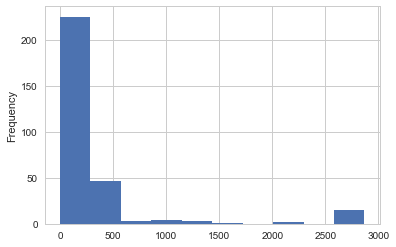

In [377]:
gtex.isnull().sum().plot(kind='hist');

In [378]:
n = gtex.shape[0] * 0.75  # Drop columns missing more than 25% of data

gtex.dropna(thresh=int(n), axis=1, inplace=True)
print 'Number of Features: {}'.format(gtex.shape[1])

Number of Features: 272


We can also drop any features that have only one unique value as they contribute no information

In [379]:
for feature in gtex.columns:
    n = gtex[feature].unique()
    if len(n) == 1:
        print 'Dropping: {}\t{}'.format(feature, n[0])
        gtex.drop(feature, axis=1, inplace=True)
    if len(n) == 2:
        if np.nan in list(n):
            print 'Dropping: {}\t{}'.format(feature, n)
            gtex.drop(feature, axis=1, inplace=True)
print 'Number of Features: {}'.format(gtex.shape[1])

Dropping: AssemblyName	GRCh37
Dropping: LibraryStrategy	RNA-Seq
Dropping: LibrarySelection	cDNA
Dropping: LibrarySource	TRANSCRIPTOMIC
Dropping: LibraryLayout	PAIRED
Dropping: Platform	ILLUMINA
Dropping: Model	Illumina HiSeq 2000
Dropping: SRAStudy	SRP012682
Dropping: BioProject	PRJNA75899
Dropping: ProjectID	75899
Dropping: SampleType	simple
Dropping: TaxID	9606
Dropping: ScientificName	Homo sapiens
Dropping: Tumor	no
Dropping: Analyte_Type	RNA:Total RNA
Dropping: CenterName	BI
Dropping: dbgap_study_accession	phs000424
Dropping: Consent	GRU
Dropping: SMCAT	['Aqua Kit: Organ and Tissue Donation' nan]
Dropping: SMMTRLTP	Tissue:PAXgene Preserved
Dropping: SMSTYP	Normal
Dropping: ANALYTE_TYPE	RNA:Total RNA
Dropping: SMAFRZE	['USE ME' nan]
Dropping: HGHTU	in
Dropping: WGHTU	lb
Dropping: DTHFUCODDU	['hour' nan]
Dropping: DTHCODDU	['hour' nan]
Dropping: DTHLUCODDU	['hour' nan]
Dropping: DTHRFGDU	['hour' nan]
Dropping: DTHVNTDU	['hour' nan]
Number of Features: 242


How many of each column type do we have?

In [380]:
gb_type = gtex.columns.to_series().groupby(gtex.dtypes).groups
gb_type = {k.name: v for k, v in gb_type.items()}

In [381]:
for k in gb_type:
    print 'Type: {}\tNum Features: {}'.format(k, len(gb_type[k]))

Type: object	Num Features: 53
Type: int64	Num Features: 14
Type: float64	Num Features: 175


All "object" types represent categorical variables (unless pandas got confused) and int64 and float64 are continuous variables.

In [382]:
print 'Number of samples with NaNs: {} / {}'.format(gtex.loc[gtex.isnull().sum(axis=1) > 0].shape[0], gtex.shape[0])
print 'Number of columns with NaNs: {} / {}'.format(len(gtex.columns[gtex.isnull().sum() > 0]), gtex.shape[1])

Number of samples with NaNs: 676 / 2868
Number of columns with NaNs: 193 / 242


We have two options at this point: drop rows with missing values or attempt imputation of missing values.

### 1. Drop Rows with Missing Values

In [383]:
dr = gtex.dropna()
dr_sample = dr.SAMPID
dr.shape

(2192, 242)

In [384]:
dr_type = dr.columns.to_series().groupby(dr.dtypes).groups
dr_type = {k.name: v for k, v in dr_type.items()}

Drop categorical features with number of unique features equal to samples

In [385]:
n = dr.shape[0]
for feature in dr[dr_type['object']]:
    if len(dr[feature].unique()) == n:
        print 'Dropping Feature: {}'.format(feature)
        dr.drop(feature, axis=1, inplace=True)
        dr_type['object'].remove(feature)
dr.shape

2192 2192
Dropping Feature: Run
2192

/Users/Jvivian/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


 2192
Dropping Feature: BigWigPath
2192 2192
Dropping Feature: SAMPID
2192 2192
Dropping Feature: download_path
2192 2192
Dropping Feature: Experiment
2192 2192
Dropping Feature: LibraryName
2192 2192
Dropping Feature: Sample
2192 2192
Dropping Feature: BioSample
2192 2192
Dropping Feature: SampleName
2192 2192
Dropping Feature: RunHash
2192 2192
Dropping Feature: ReadHash


(2192, 231)

#### Task: Tissue Classification

Drop all features related to tissue location

In [401]:
dr_reduced = dr.drop(['Histological_Type', 'SMSMPSTE', 'SMTSD', 'SMUBRID', 'SMUBRTRM', 'SMTS', 'SMTSD', 'SMSMPSTE'], axis=1)

In [402]:
y = dr_reduced.Body_Site
X = dr_reduced.drop('Body_Site', axis=1)

In [403]:
def return_ohe_scaled_df(df):
    # Get types
    df_type = df.columns.to_series().groupby(df.dtypes).groups
    df_type = {k.name: v for k, v in df_type.items()}
    
    # One-Hot-Encode all categorical variables
    df_ohe = pd.get_dummies(df, columns=df_type['object'])
    df_ohe = df_ohe.reset_index(drop=True)
    
    # Separate out continuous variables and scale
    df_cont = scale(df[df_type['float64'] + df_type['int64']])

    robust_scaler = RobustScaler()
    df_cont_rob = robust_scaler.fit_transform(scale(df[df_type['float64'] + df_type['int64']]))
    
    # Combine
    df_X = pd.concat([df_ohe, pd.DataFrame(df_cont, columns=df_type['float64'] + df_type['int64'])], axis=1)
    df_X_rob = pd.concat([df_ohe, pd.DataFrame(df_cont_rob, columns=df_type['float64'] + df_type['int64'])], axis=1)
    return df_X, df_X_rob

In [404]:
X, X_rob = return_ohe_scaled_df(X)

In [405]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [414]:
models = [RandomForestClassifier(), ExtraTreesClassifier(), GradientBoostingClassifier(), AdaBoostClassifier()]
score = 0
for model in models:
    model.fit(X_train, y_train)
    print model.score(X_test, y_test)
    if model.score(X_test, y_test) > score:
        score = model.score(X_test, y_test) 
        best_model = model

0.430656934307
0.35401459854
0.520072992701
0.215328467153


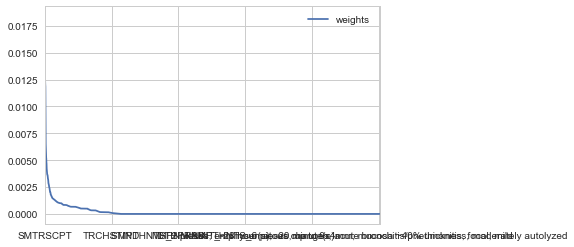

In [415]:
weights = pd.DataFrame()
weights['weights'] = best_model.feature_importances_
weights.index = X.columns
weights.sort_values('weights', ascending=False, inplace=True)
weights.plot()

In [417]:
weights.head(50)

,weights
SMTRSCPT,0.018401
"SMPTHNTS_4 aliquots, ~ 7x7mm. One shows endocervical surface mucosa with early squamous metaplasia encircled, and deeper endocervical glands en squared; other 3 with no glands, only stroma",0.016121
SMPTHNTS_6 pieces up to 8x5 mm; only one piece has mucosa,0.013280
SMPTHNTS_2 pieces 9x6 & 11x8 mm; well preserved,0.012908
"SMPTHNTS_4 aliquots, ~ 12x9mm. 3 show focal squamous mucosa, ~100 microns thick, encircled; one with single layer endocervical mucosa, 10 microns thick, en squared",0.012809
"SMPTHNTS_4 pieces ~10x6mm a few foci of endocervical glands well preserved, encircled, up to ~1.5mm d.",0.012711
SMPTHNTS_6 pieces up to 8x4 mm; mucosa is variably preserved: some areas well and some sloughed,0.012320
SMTRSCPT,0.012216
SMNABTCH_BP-25328,0.012077
SMPTHNTS_6 pieces up to 10x5 mm; mucosa not in sections,0.011920


In [418]:
pd.read_excel('GTEx_Data_V6_Annotations_SampleAttributesDD.xlsx')

,VARNAME,VARDESC,DOCFILE,TYPE,UNITS,COMMENT1,COMMENT2,VALUES,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,Unnamed: 40,Unnamed: 41,Unnamed: 42,Unnamed: 43,Unnamed: 44,Unnamed: 45,Unnamed: 46,Unnamed: 47,Unnamed: 48,Unnamed: 49,Unnamed: 50,Unnamed: 51,Unnamed: 52,Unnamed: 53,Unnamed: 54,Unnamed: 55,Unnamed: 56
0,SAMPID,"Sample ID, GTEx Public Sample ID",NaN,string,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,SMATSSCR,Autolysis Score,PRC Case Summary Report,"integer, encoded value",NaN,Autolysis,The destruction of organism cells or tissues b...,0=None,1=Mild,2=Moderate,3=Severe,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,SMNABTCH,Nucleic Acid Isolation Batch ID,LDACC,string,NaN,Generated at LDACC,Batch when DNA/RNA was isolated and extracted ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,SMNABTCHT,Type of nucleic acid isolation batch,LDACC,string,NaN,Generated at LDACC,The process by which DNA/RNA was isolated,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,SMNABTCHD,Date of nucleic acid isolation batch,LDACC,string,NaN,Generated at LDACC,The date on which DNA/RNA was isolated,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,SMGEBTCH,Genotype or Expression Batch ID,LDACC,string,NaN,Generated at LDACC,Batch when DNA/RNA from a sample was analyzed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,SMGEBTCHD,Date of genotype or expression batch,LDACC,string,NaN,Generated at LDACC,The data on which DNA/RNA was analyzed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,SMGEBTCHT,Type of genotype or expression batch,LDACC,string,NaN,Generated at LDACC,The technology used to analyze DNA/RNA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,SMCENTER,Code for BSS collection site,LDACC,string,NaN,Coded site or center,"Indicates the site that enrolled the donor, br...",B1,C1,D1,"B1, A1","C1, A1","D1, A1",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,SMPTHNTS,"Pathology Notes, notes from PRC Report",PRC Case Summary Report,string,NaN,Comments from pathological review,Any comments the pathologist filling out the P...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Attempt Imputation of Missing Values

Columns with NaNs do not work well with SKLearn classifiers, so we either have to drop them or impute them.

In [228]:
from sklearn.preprocessing import scale
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import Imputer

How many columns of our continuous data need to be replaced?

In [238]:
gtex[gb_type['float64'] + gb_type['int64']].isnull().sum(axis=1) > 0

9       False
17      False
21      False
22      False
30      False
33      False
36      False
39      False
43      False
44      False
45      False
47       True
48      False
49       True
50      False
52      False
54      False
59      False
62       True
63      False
64      False
67      False
70      False
71       True
73      False
74      False
75      False
77      False
79      False
85      False
86      False
89      False
        ...  
9559    False
9561    False
9563    False
9573    False
9574    False
9578     True
9580    False
9581    False
9583    False
9585     True
9586    False
9588     True
9592    False
9596    False
9599    False
9601    False
9603    False
9604    False
9606    False
9608    False
9609    False
9616    False
9621    False
9624     True
9628    False
9635    False
9643    False
9649    False
9652    False
9655    False
9658     True
9660    False
dtype: bool

Scale data